<a href="https://colab.research.google.com/github/nupoorsagar/Denoising_ECG/blob/main/wavelet_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wfdb matplotlib numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 61.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.


In [ ]:
!pip install PyWavelets

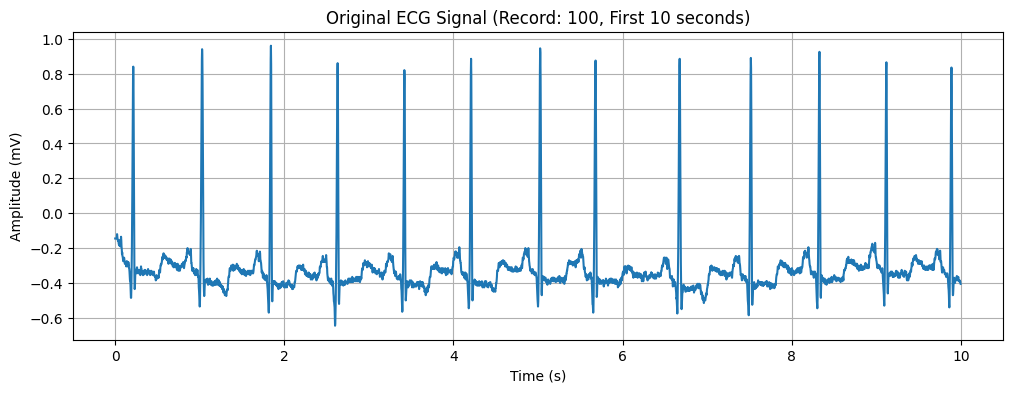

In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

# 1. Load a record from the MIT-BIH Arrhythmia Database
record_name = '100'
record = wfdb.rdrecord(record_name, pn_dir='mitdb/1.0.0/')

# 2. Extract the ECG signal from the first channel
signal = record.p_signal[:, 0]
fs = record.fs  # Get the sampling frequency

# 3. Visualize the first 10 seconds of the original signal
time = np.arange(signal.size) / fs
plt.figure(figsize=(12, 4))
plt.plot(time[:fs*10], signal[:fs*10])
plt.title(f'Original ECG Signal (Record: {record_name}, First 10 seconds)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.grid(True)
plt.show()

In [ ]:
import pywt

def wavelet_denoising(signal, wavelet='sym8', level=1):
    """
    Performs wavelet denoising on a signal.

    Parameters:
    - signal (np.array): The input signal.
    - wavelet (str): The type of wavelet to use (e.g., 'db4', 'sym8').
    - level (int): The level of decomposition.

    Returns:
    - np.array: The denoised signal.
    """
    # 1. Decompose the signal
    # 'per' mode is used to handle border distortions
    coeffs = pywt.wavedec(signal, wavelet, mode='per', level=level)

    # 2. Calculate the threshold
    # We use the Median Absolute Deviation (MAD) for a robust noise estimate
    sigma = (1/0.6745) * np.median(np.abs(coeffs[-1] - np.median(coeffs[-1])))
    # The Universal Threshold is a common choice for denoising
    threshold = sigma * np.sqrt(2 * np.log(len(signal)))

    # 3. Apply soft thresholding to the detail coefficients
    coeffs_thresholded = coeffs[:] # Create a copy
    for i in range(1, len(coeffs)):
        coeffs_thresholded[i] = pywt.threshold(coeffs[i], value=threshold, mode='soft')

    # 4. Reconstruct the signal from the thresholded coefficients
    denoised_signal = pywt.waverec(coeffs_thresholded, wavelet, mode='per')

    return denoised_signal

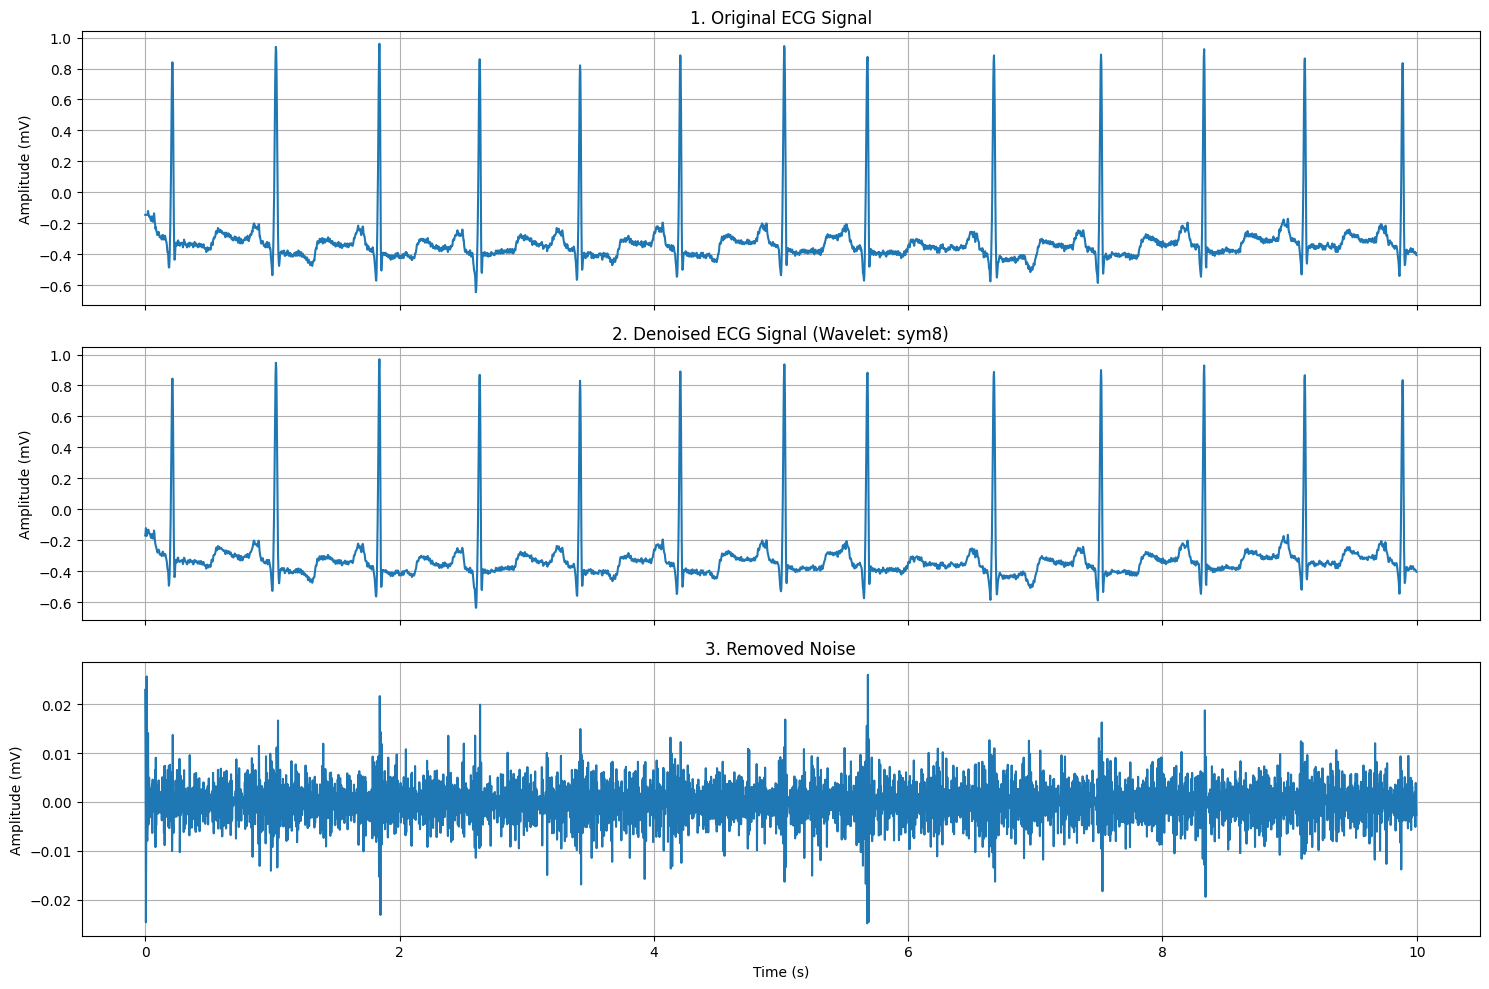

In [ ]:
# Apply the wavelet denoising function to your signal
denoised_signal = wavelet_denoising(signal, wavelet='sym8', level=1)

# Ensure the denoised signal has the same length as the original
# This is sometimes necessary due to padding in the wavelet transform
denoised_signal = denoised_signal[:len(signal)]

# Calculate the noise that was removed
removed_noise = signal - denoised_signal

# --- Plotting the results for comparison ---
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

# Plot Original Signal
axes[0].plot(time[:fs*10], signal[:fs*10])
axes[0].set_title('1. Original ECG Signal')
axes[0].set_ylabel('Amplitude (mV)')
axes[0].grid(True)

# Plot Denoised Signal
axes[1].plot(time[:fs*10], denoised_signal[:fs*10])
axes[1].set_title('2. Denoised ECG Signal (Wavelet: sym8)')
axes[1].set_ylabel('Amplitude (mV)')
axes[1].grid(True)

# Plot Removed Noise
axes[2].plot(time[:fs*10], removed_noise[:fs*10])
axes[2].set_title('3. Removed Noise')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Amplitude (mV)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

Percent Root-mean-square Difference (PRD): 1.21%


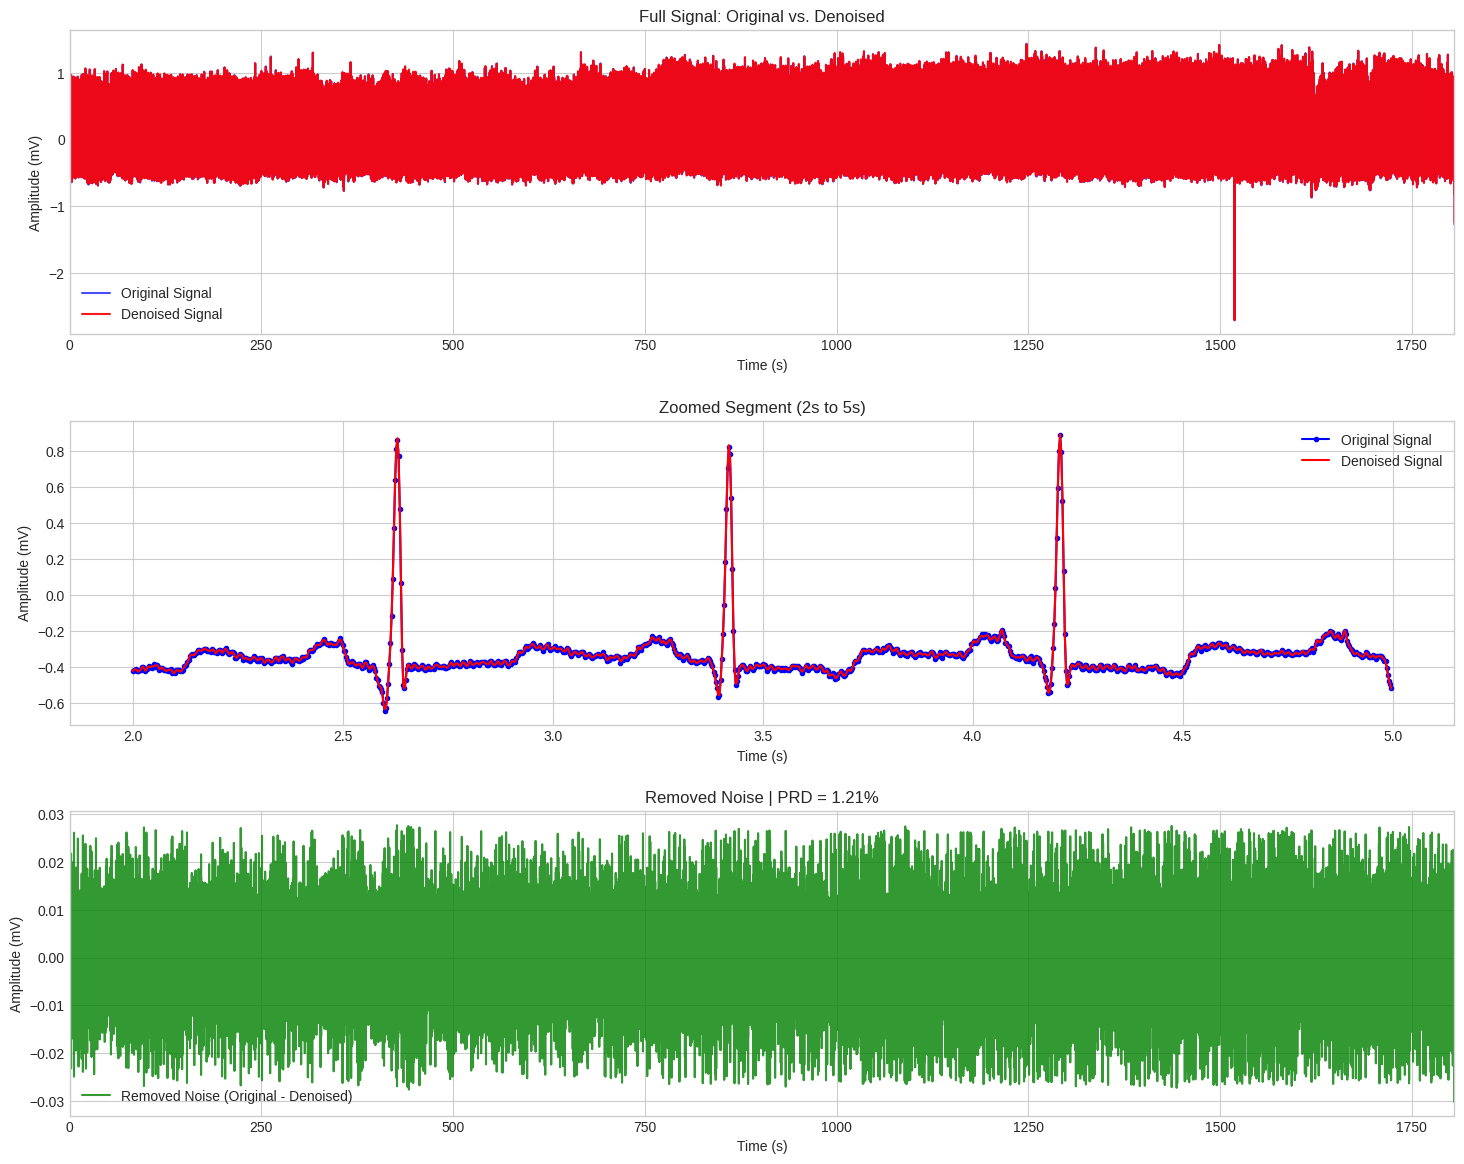

In [ ]:
# 5. Function to calculate PRD
def calculate_prd(original_signal, denoised_signal):
    """
    Calculates the Percent Root-mean-square Difference (PRD).
    """
    # Ensure signals are numpy arrays for vectorized operations
    original_signal = np.asarray(original_signal)
    denoised_signal = np.asarray(denoised_signal)

    # Calculate the numerator (sum of squared differences)
    numerator = np.sum((original_signal - denoised_signal) ** 2)

    # Calculate the denominator (sum of squared original signal)
    denominator = np.sum(original_signal ** 2)

    if denominator == 0:
        return np.inf # Avoid division by zero

    prd = np.sqrt(numerator / denominator) * 100
    return prd

# Calculate the PRD for our signals
prd_value = calculate_prd(signal, denoised_signal)
print(f"Percent Root-mean-square Difference (PRD): {prd_value:.2f}%")

# --- Plotting Section ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharex=False)

# Plot 1: Full Segment Comparison
axs[0].plot(time, signal, label='Original Signal', color='blue', alpha=0.7)
axs[0].plot(time, denoised_signal, label='Denoised Signal', color='red', alpha=0.9)
axs[0].set_title('Full Signal: Original vs. Denoised')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude (mV)')
axs[0].legend()
axs[0].set_xlim([time[0], time[-1]])

# Plot 2: Zoomed Segment Comparison
# Define the time window for the zoom (e.g., from 2 to 5 seconds)
zoom_start_time = 2
zoom_end_time = 5
start_index = int(zoom_start_time * fs)
end_index = int(zoom_end_time * fs)

axs[1].plot(time[start_index:end_index], signal[start_index:end_index], label='Original Signal', color='blue', marker='.', linestyle='-')
axs[1].plot(time[start_index:end_index], denoised_signal[start_index:end_index], label='Denoised Signal', color='red')
axs[1].set_title('Zoomed Segment (2s to 5s)')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Amplitude (mV)')
axs[1].legend()

# Plot 3: Removed Noise and PRD Display
axs[2].plot(time, removed_noise, label='Removed Noise (Original - Denoised)', color='green', alpha=0.8)
axs[2].set_title(f'Removed Noise | PRD = {prd_value:.2f}%')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Amplitude (mV)')
axs[2].legend()
axs[2].set_xlim([time[0], time[-1]])

plt.tight_layout(pad=2.0)
plt.show()